## Load and inspect data

In [109]:
# import pandas
import pandas as pd

# load the data
csv_path = "data/deaths.csv"
deaths_df = pd.read_csv(csv_path)

In [110]:
# inspect the data
deaths_df.info()
deaths_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9919 entries, 0 to 9918
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   total_fatalities            9919 non-null   int64 
 1   govt_official_fatalities    9919 non-null   int64 
 2   civilian_fatalities         9919 non-null   int64 
 3   security_fatalities         9919 non-null   int64 
 4   maoist_fatalities           9919 non-null   int64 
 5   other_armed_grp_fatalities  9919 non-null   int64 
 6   incident_summary            9919 non-null   object
dtypes: int64(6), object(1)
memory usage: 542.6+ KB


,total_fatalities,govt_official_fatalities,civilian_fatalities,security_fatalities,maoist_fatalities,other_armed_grp_fatalities,incident_summary
0,0,0,0,0,0,0,An alleged arms supplier to the Communist Part...
1,0,0,0,0,0,0,A Kamareddy dalam (squad) member belonging to ...
2,0,0,0,0,0,0,Senior CPI-Maoist 'Polit Bureau' and 'central ...
3,1,1,0,0,0,0,A TDP leader and former Sarpanch of Jerrela Gr...
4,0,0,0,0,0,0,The CPI-Maoist cadres blasted coffee pulping u...


In [111]:
# check for missing values
deaths_df.isnull().sum()
#deaths_df[deaths_df.isnull().any(axis=1)]

total_fatalities              0
govt_official_fatalities      0
civilian_fatalities           0
security_fatalities           0
maoist_fatalities             0
other_armed_grp_fatalities    0
incident_summary              0
dtype: int64

In [112]:
# inspect the frequencies of the different categories
deaths_data = deaths_df.iloc[:, :7]  
deaths_data.describe()

,total_fatalities,govt_official_fatalities,civilian_fatalities,security_fatalities,maoist_fatalities,other_armed_grp_fatalities
count,9919.000000,9919.000000,9919.000000,9919.000000,9919.000000,9919.000000
mean,0.673959,0.044057,0.215748,0.175824,0.230366,0.007158
std,2.657038,0.401367,1.726696,1.476760,1.148950,0.120701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,148.000000,31.000000,148.000000,76.000000,30.000000,4.000000


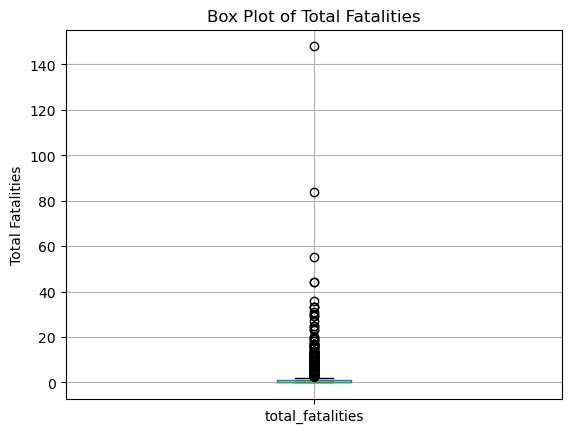

In [113]:
# make a boxplot
deaths_df.boxplot(column=['total_fatalities'])
plt.title('Box Plot of Total Fatalities')
plt.ylabel('Total Fatalities')
plt.show()

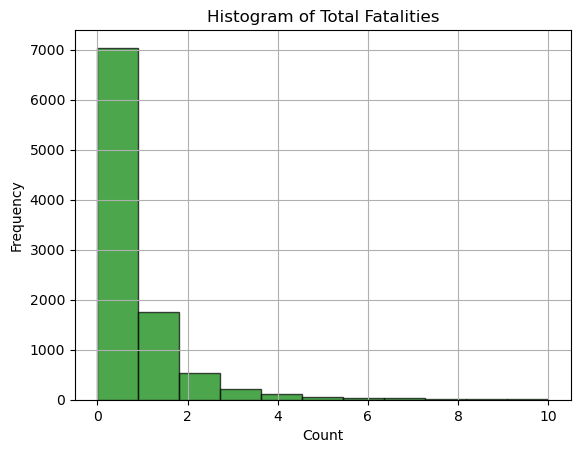

In [114]:
# view total_fatalities with a 
import matplotlib.pyplot as plt

deaths_df['total_fatalities'].hist(bins=11, alpha=0.7, color='green', edgecolor='black', range=(0, 10))
plt.title('Histogram of Total Fatalities')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()


The counts are very skewed. As with most event-count data of this nature there is evidence of over-dispersion (lots of zeros and some big outlier counts). Therefore, we might think about developing a custom zero-inflated negative binomial (ZINB) model for the final layer of the neural network.

In [116]:
import numpy as np

# bin the data
y = deaths_df['total_fatalities']
bins = [0, 1, 2, 4, 9, np.inf]
y_binned = np.digitize(y, bins, right=True)

# add y_binned to the data frame
deaths_df['y_binned'] = y_binned

# count occurrences in each bin
deaths_df['y_binned'].value_counts(normalize=True)


y_binned
0    0.709749
1    0.176328
2    0.054340
3    0.033874
4    0.016937
5    0.008771
Name: proportion, dtype: float64

## Apply train-test split

In [213]:
from sklearn.model_selection import train_test_split

# separate text summaries and labels into X and 
X = deaths_df['incident_summary']  # text summaries
#y = deaths_df.drop(['incident_summary'], axis=1)  # columns with death totals
y = deaths_df[['total_fatalities', 'y_binned']] # only total fatalities

# separate the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=deaths_df['y_binned'])

# separate the validation set from the training set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val['y_binned'])

# Note: Adjusting `test_size` in the second split to 0.25 means that
# 25% of the training+validation set becomes the validation set,
# and 75% remains as the training set.

## Recombine data frames

In [214]:
# recombine the features and labels into pandas DataFrames
train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val_df = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

## Check the data

In [215]:
# check df
train_df.info()

# make sure bin counts look right
train_df['y_binned'].value_counts(normalize=True).sort_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5951 entries, 0 to 5950
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   incident_summary  5951 non-null   object
 1   total_fatalities  5951 non-null   int64 
 2   y_binned          5951 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 139.6+ KB


y_binned
0    0.709797
1    0.176273
2    0.054277
3    0.033944
4    0.016804
5    0.008906
Name: proportion, dtype: float64

In [216]:
# check df
val_df.info()

# make sure bin counts look right
val_df['y_binned'].value_counts(normalize=True).sort_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   incident_summary  1984 non-null   object
 1   total_fatalities  1984 non-null   int64 
 2   y_binned          1984 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 46.6+ KB


y_binned
0    0.709677
1    0.176411
2    0.054435
3    0.033770
4    0.017137
5    0.008569
Name: proportion, dtype: float64

In [217]:
# check df
test_df.info()

# make sure bin counts look right
val_df['y_binned'].value_counts(normalize=True).sort_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   incident_summary  1984 non-null   object
 1   total_fatalities  1984 non-null   int64 
 2   y_binned          1984 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 46.6+ KB


y_binned
0    0.709677
1    0.176411
2    0.054435
3    0.033770
4    0.017137
5    0.008569
Name: proportion, dtype: float64

In [218]:
train_df = train_df.drop('y_binned', axis=1)
train_df.head()

,incident_summary,total_fatalities
0,"Sashadhar Mahato alias Kiran, a top ranking ca...",1
1,At least seven cadres of CPI-Maoist and a cons...,0
2,The CRPF personnel recovered a landmine weighi...,0
3,Five suspected cadres of the CPI-Maoist-backed...,0
4,Three CPI-Maoist cadres were killed by the Pol...,3


In [219]:
val_df = val_df.drop('y_binned', axis=1)
val_df.head()

,incident_summary,total_fatalities
0,An auto rickshaw driver was injured when a gro...,0
1,Five CPI-Maoist cadres including three females...,0
2,Police claimed to have arrested a woman CPI-Ma...,0
3,About 50 security personnel had a close shave ...,0
4,"Five suspected Maoists - Kailash Modok, Kinkor...",0


In [220]:
test_df = test_df.drop('y_binned', axis=1)
test_df.head()

,incident_summary,total_fatalities
0,A CPI-Maoist cadre is suspected to have sustai...,0
1,"A Police constable, Dhananjay Mhaske was kille...",1
2,"Disillusioned with the Maoist ideology, two Ma...",0
3,"CPI-Maoist cadres shot dead Nand Kumar Singh, ...",1
4,Six Maoist sympathizers were arrested from Dar...,0


## Set up custom data loader

In [221]:
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

## Tokenize and load data

In [222]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 512

# Training set
texts = train_df['incident_summary'].tolist() # text data to list
labels = train_df.drop(['incident_summary'], axis=1).values.tolist() # labels to list
train_dataset = CustomDataset(texts, labels, tokenizer, max_length)

# Validation set
texts = val_df['incident_summary'].tolist()
labels = val_df.drop(['incident_summary'], axis=1).values.tolist() # labels to list
val_dataset = CustomDataset(texts, labels, tokenizer, max_length)

# Test set
texts = test_df['incident_summary'].tolist()
labels = test_df.drop(['incident_summary'], axis=1).values.tolist() # labels to list
test_dataset = CustomDataset(texts, labels, tokenizer, max_length)

## Inspect training, validation and test datasets

In [223]:
# Inspect an example of the training set
import torch
print(train_dataset[1])

{'input_ids': tensor([  101,  2012,  2560,  2698, 28353,  6072,  1997, 28780,  1011, 15158,
         2923,  1998,  1037, 12294,  1997, 21220,  1010,  8760,  6441,  1999,
         2019,  3863,  1997,  2543,  2076,  1037, 22863,  2075,  3169,  1999,
         1996,  3224,  2181,  2090, 24188,  2721,  1998,  8934,  5400,  2213,
         4731,  1999,  1047,  3511,  2863,  2213,  2212,  1997, 14065,  7970,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [224]:
# Inspect an example of the validation set
print(val_dataset[1])

{'input_ids': tensor([  101,  2274, 28780,  1011, 15158,  2923, 28353,  6072,  2164,  2093,
         3801, 10795,  1999, 15451,  9126, 23243,  2212,  1012, 21874,  2231,
         2018,  4161,  1999,  2099,  2531,  1010,  2199, 10377,  2006,  4641,
         1997,  2169,  1997,  2048,  3287, 28353,  6072,  4942,  3676,  5506,
        27052,  2072,  1006,  2570,  1007,  1998,  2061,  2863, 11687, 25107,
         2072,  1006,  3486,  1007,  2040, 10795,  1012,  1996,  2093, 10795,
         2931, 15158,  5130,  2020,  2139,  4783,  5506, 27052,  2072,  1006,
         2382,  1007,  1010,  2474,  2912, 10556, 17311,  2072,  1006,  2423,
         1007,  1998,  1038, 14341,  2063,  5506,  4048,  1006,  2423,  1007,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [225]:
# Inspect an example of the test set
print(test_dataset[1])

{'input_ids': tensor([  101,  1037,  2610, 12294,  1010, 28144,  5162,  2078,  3900,  2100,
         1049, 14949,  3489,  2001,  2730,  1999,  2019,  8087,  2090,  2569,
         3169,  4686,  1998, 28780,  1011, 15158,  2923, 28353,  6072,  2379,
        22827,  3527,  3669,  2352,  1999, 27859, 12952,  3669, 20751,  1997,
        11721, 16409, 18334,  3669,  2212,  1012,  2096,  2093,  2062, 12294,
         2015,  1010, 17429, 26136, 20697,  2072,  1010, 10975, 11823,  4630,
        20437,  5400,  2213,  1998,  3103,  4014,  9538,  2020,  5229,  1999,
         1996,  5043,  1012,  2610,  4216,  2056,  2008,  1037,  1039,  1011,
         3438,  2283,  2001,  4755,  2041,  3424,  1011, 15158,  5130,  3136,
         1999,  1996,  8894,  2379, 22827,  3527,  3669,  2352,  2043, 24261,
        15158,  5130, 22168,  1996, 26246,  2012,  2105,  1018,  9737,  1010,
         2429,  2000,  1996,  2335,  1997,  2634,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0, 

## Define the model

In [233]:
from torch.nn import PoissonNLLLoss, Linear
from transformers import AutoModel, Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput

class PoissonRegressionModel(torch.nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name)  # use AutoModel to load the pre-trained model
        self.regressor = Linear(self.bert.config.hidden_size, num_labels)  # assuming num_labels is the output dimension
        
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0][:, 0, :]  # take the [CLS] token's embeddings
        logits = self.regressor(sequence_output).squeeze(-1) # add this for single output model: .squeeze(-1)
        
        loss = None
        if labels is not None:
            # Use Poisson loss
            loss_fct = PoissonNLLLoss(log_input=False)  # log_input=False means the input is expected to be the mean of the Poisson distribution
            loss = loss_fct(logits, labels.float())  # ensure labels are float for PoissonNLLLoss
            
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

num_labels = 1
model = PoissonRegressionModel(pretrained_model_name='distilbert-base-uncased', num_labels=num_labels) 


## Define evaluation metrics

In [234]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions
    
    # Check if preds is one-dimensional (single output case)
    if preds.ndim == 1:
        preds = preds.reshape(-1, 1)
        labels = labels.reshape(-1, 1)
    
    mse_list = []
    rmse_list = []
    mae_list = []

    # calculate metrics for each category
    for i in range(preds.shape[1]):  # works for both single and multiple outputs
        mse = mean_squared_error(labels[:, i], preds[:, i])
        rmse = sqrt(mse)
        mae = mean_absolute_error(labels[:, i], preds[:, i])
        
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
    
    # calculate metrics across all categories
    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    avg_mae = np.mean(mae_list)
    
    return {
        'avg_mse': avg_mse,
        'avg_rmse': avg_rmse,
        'avg_mae': avg_mae
    }


# probably also want to include deviance, pearson chi-squared a log-likelihood 
# not supported by scikitlearn, so would have to find another package or write manually


## Define trainer configuration

In [235]:
from transformers import TrainerCallback
from transformers import Trainer

# create custom callback
# class DebuggingCallback(TrainerCallback):
#     def on_step_end(self, args, state, control, **kwargs):
#         # Check if log_history is not empty and contains a 'loss' key in the last entry
#         if state.log_history and 'loss' in state.log_history[-1]:
#             print(f"Step {state.global_step}, Loss: {state.log_history[-1]['loss']}")
#         else:
#             print(f"Step {state.global_step}, Loss information not available yet.")


# specify training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_strategy="steps",  # Log every X steps
    logging_steps=200,  # Number of steps to log after
    logging_dir='./logs',
    evaluation_strategy='epoch',  # Evaluate at the end of each epoch
    #learning_rate=1e-4  
)

# finalize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    #callbacks=[DebuggingCallback()],  # Add the debugging callback
    compute_metrics=compute_metrics  # use the adjusted compute_metrics for regression
)

/Users/ejt/anaconda3/envs/code-satp/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## Train the model

In [236]:
trainer.train()

  4%|▍         | 200/4464 [01:08<24:11,  2.94it/s]
                                              

                                                  
  4%|▍         | 200/4464 [01:08<24:11,  2.94it/s]

{'loss': 1.1948, 'grad_norm': 35.91277313232422, 'learning_rate': 2e-05, 'epoch': 0.13}


  9%|▉         | 400/4464 [02:16<22:59,  2.95it/s]
                                              

                                                  
  9%|▉         | 400/4464 [02:16<22:59,  2.95it/s]

{'loss': 1.0806, 'grad_norm': 4.360297679901123, 'learning_rate': 4e-05, 'epoch': 0.27}


 13%|█▎        | 600/4464 [03:26<22:07,  2.91it/s]
                                              

                                                  
 13%|█▎        | 600/4464 [03:26<22:07,  2.91it/s]

{'loss': 0.9107, 'grad_norm': 54.175655364990234, 'learning_rate': 4.873864783047427e-05, 'epoch': 0.4}


 18%|█▊        | 800/4464 [04:34<20:45,  2.94it/s]
                                              

                                                  
 18%|█▊        | 800/4464 [04:34<20:45,  2.94it/s]

{'loss': 0.9949, 'grad_norm': 15.177800178527832, 'learning_rate': 4.621594349142281e-05, 'epoch': 0.54}


 22%|██▏       | 1000/4464 [05:43<19:41,  2.93it/s]
                                              

                                                   
 22%|██▏       | 1000/4464 [05:43<19:41,  2.93it/s]Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.9711, 'grad_norm': 1.1684352159500122, 'learning_rate': 4.3693239152371344e-05, 'epoch': 0.67}


 27%|██▋       | 1200/4464 [06:53<19:22,  2.81it/s]
                                              

                                                   
 27%|██▋       | 1200/4464 [06:53<19:22,  2.81it/s]

{'loss': 1.0467, 'grad_norm': 6.62337589263916, 'learning_rate': 4.1170534813319885e-05, 'epoch': 0.81}


 31%|███▏      | 1400/4464 [08:01<17:16,  2.96it/s]
                                              

                                                   
 31%|███▏      | 1400/4464 [08:01<17:16,  2.96it/s]

{'loss': 1.0887, 'grad_norm': 111.62879943847656, 'learning_rate': 3.864783047426841e-05, 'epoch': 0.94}


 33%|███▎      | 1488/4464 [08:31<15:49,  3.13it/s]




































































































































































































































































































































































































































































































































                                              

                                                   


                                        
 33%|███▎      | 1488/4464 [09:19<15:49,  3.13it/s]





{'eval_loss': 1.0080649852752686, 'eval_avg_mse': 17.239944458007812, 'eval_avg_rmse': 4.15210120999089, 'eval_avg_mae': 0.8209659457206726, 'eval_runtime': 48.2384, 'eval_samples_per_second': 41.129, 'eval_steps_per_second': 10.282, 'epoch': 1.0}


 36%|███▌      | 1600/4464 [09:59<16:08,  2.96it/s]   
                                              

                                                   
 36%|███▌      | 1600/4464 [09:59<16:08,  2.96it/s]

{'loss': 1.0019, 'grad_norm': 13.527796745300293, 'learning_rate': 3.6125126135216953e-05, 'epoch': 1.08}


 40%|████      | 1800/4464 [11:08<15:13,  2.92it/s]
                                              

                                                   
 40%|████      | 1800/4464 [11:08<15:13,  2.92it/s]

{'loss': 0.9502, 'grad_norm': 19.335796356201172, 'learning_rate': 3.360242179616549e-05, 'epoch': 1.21}


 45%|████▍     | 2000/4464 [12:16<13:53,  2.95it/s]
                                              

                                                   
 45%|████▍     | 2000/4464 [12:16<13:53,  2.95it/s]

{'loss': 0.9814, 'grad_norm': 7.545084476470947, 'learning_rate': 3.107971745711403e-05, 'epoch': 1.34}


 49%|████▉     | 2200/4464 [13:26<12:48,  2.95it/s]
                                              

                                                   
 49%|████▉     | 2200/4464 [13:26<12:48,  2.95it/s]

{'loss': 0.9301, 'grad_norm': 13.242244720458984, 'learning_rate': 2.8557013118062566e-05, 'epoch': 1.48}


 54%|█████▍    | 2400/4464 [14:34<11:41,  2.94it/s]
                                              

                                                   
 54%|█████▍    | 2400/4464 [14:34<11:41,  2.94it/s]

{'loss': 1.008, 'grad_norm': 12.271272659301758, 'learning_rate': 2.6034308779011103e-05, 'epoch': 1.61}


 58%|█████▊    | 2600/4464 [15:44<10:32,  2.95it/s]
                                              

                                                   
 58%|█████▊    | 2600/4464 [15:44<10:32,  2.95it/s]

{'loss': 0.9541, 'grad_norm': 25.857072830200195, 'learning_rate': 2.3511604439959638e-05, 'epoch': 1.75}


 63%|██████▎   | 2800/4464 [16:52<09:24,  2.95it/s]
                                              

                                                   
 63%|██████▎   | 2800/4464 [16:52<09:24,  2.95it/s]

{'loss': 1.0677, 'grad_norm': 12.540223121643066, 'learning_rate': 2.0988900100908175e-05, 'epoch': 1.88}


 67%|██████▋   | 2976/4464 [17:51<07:55,  3.13it/s]















































































































































































































































































































































































































































































































                                                   


                                        
                                              

 67%|██████▋   | 2976/4464 [18:40<07:55,  3.13it/s]






{'eval_loss': 0.9852076172828674, 'eval_avg_mse': 16.604825973510742, 'eval_avg_rmse': 4.074901958760571, 'eval_avg_mae': 0.7683083415031433, 'eval_runtime': 48.1095, 'eval_samples_per_second': 41.239, 'eval_steps_per_second': 10.31, 'epoch': 2.0}


                                                     
                                              

 67%|██████▋   | 3000/4464 [18:48<08:22,  2.91it/s]


{'loss': 0.8656, 'grad_norm': 24.606307983398438, 'learning_rate': 1.8466195761856713e-05, 'epoch': 2.02}


                                                   
                                              

 72%|███████▏  | 3200/4464 [19:58<07:08,  2.95it/s]


{'loss': 0.9179, 'grad_norm': 4.5435590744018555, 'learning_rate': 1.594349142280525e-05, 'epoch': 2.15}


                                                   
                                              

 76%|███████▌  | 3400/4464 [21:05<06:02,  2.94it/s]


{'loss': 0.8848, 'grad_norm': 12.899923324584961, 'learning_rate': 1.3420787083753786e-05, 'epoch': 2.28}


                                                   
                                              

 81%|████████  | 3600/4464 [22:15<04:53,  2.95it/s]


{'loss': 0.9562, 'grad_norm': 7.634776592254639, 'learning_rate': 1.0898082744702322e-05, 'epoch': 2.42}


                                                   
                                              

 85%|████████▌ | 3800/4464 [23:23<03:42,  2.98it/s]


{'loss': 0.9475, 'grad_norm': 6.914658546447754, 'learning_rate': 8.375378405650857e-06, 'epoch': 2.55}


                                                   
                                              

 90%|████████▉ | 4000/4464 [24:30<02:34,  3.00it/s]


{'loss': 0.9099, 'grad_norm': 21.677978515625, 'learning_rate': 5.852674066599395e-06, 'epoch': 2.69}


                                                   
                                              

 94%|█████████▍| 4200/4464 [25:38<01:27,  3.01it/s]


{'loss': 0.9865, 'grad_norm': 13.427151679992676, 'learning_rate': 3.329969727547932e-06, 'epoch': 2.82}


                                                   
                                              

 99%|█████████▊| 4400/4464 [26:45<00:21,  3.01it/s]


{'loss': 0.8905, 'grad_norm': 13.34248161315918, 'learning_rate': 8.072653884964682e-07, 'epoch': 2.96}


100%|██████████| 4464/4464 [27:06<00:00,  3.19it/s]





























































































































































































































































































































































































































































































































                                                   
                                              

                                            


100%|██████████| 4464/4464 [27:54<00:00,  3.19it/s]




                                                   
                                              

100%|██████████| 4464/4464 [27:54<00:00,  2.67it/s]

{'eval_loss': 0.9058798551559448, 'eval_avg_mse': 16.388959884643555, 'eval_avg_rmse': 4.048328035701103, 'eval_avg_mae': 0.8225284814834595, 'eval_runtime': 47.8147, 'eval_samples_per_second': 41.494, 'eval_steps_per_second': 10.373, 'epoch': 3.0}
{'train_runtime': 1674.3968, 'train_samples_per_second': 10.662, 'train_steps_per_second': 2.666, 'train_loss': 0.9777699379938051, 'epoch': 3.0}


TrainOutput(global_step=4464, training_loss=0.9777699379938051, metrics={'train_runtime': 1674.3968, 'train_samples_per_second': 10.662, 'train_steps_per_second': 2.666, 'train_loss': 0.9777699379938051, 'epoch': 3.0})

## Evaluate against the validation set

In [237]:
trainer.evaluate()

100%|██████████| 496/496 [00:48<00:00, 10.32it/s]


{'eval_loss': 0.9058798551559448,
 'eval_avg_mse': 16.388959884643555,
 'eval_avg_rmse': 4.048328035701103,
 'eval_avg_mae': 0.8225284814834595,
 'eval_runtime': 48.2693,
 'eval_samples_per_second': 41.103,
 'eval_steps_per_second': 10.276,
 'epoch': 3.0}

In [ ]:
# Assuming 'trainer' is your Trainer instance and 'val_dataset' is your validation dataset
predictions = trainer.predict(val_dataset)

# The .predictions attribute contains the raw model predictions
predicted_labels = predictions.predictions

# If your task is regression or you have direct numerical outputs, you might directly use the predictions
# For classification, convert logits to probabilities or class labels as required
# Here's an example for a regression task:
predicted_labels = predicted_labels.squeeze()

# Convert the true labels from your dataset to a list (adjust as per your dataset structure)
true_labels = [example['labels'] for example in val_dataset]

# Create a DataFrame
df_predictions = pd.DataFrame({
    'True Labels': true_labels,
    'Predicted Labels': predicted_labels  # Adjust as necessary, e.g., apply np.argmax for classification
})

# To add the textual descriptions, assuming they are stored in 'texts' attribute of val_dataset
# texts = [example['text'] for example in val_dataset]
# df_predictions['Textual Descriptions'] = texts

# Now you can review the DataFrame
print(df_predictions.head(10))

# Optionally, save the DataFrame to a CSV file
#df_predictions.to_csv("validation_predictions.csv", index=False)


In [252]:
df_predictions.loc[df_predictions['True Labels'] == 3].sample(n=30)



,True Labels,Predicted Labels
1979,[tensor(3.)],1.222413
650,[tensor(3.)],0.814608
1604,[tensor(3.)],0.864720
441,[tensor(3.)],1.006536
1616,[tensor(3.)],1.583931
468,[tensor(3.)],0.580920
1254,[tensor(3.)],0.625430
826,[tensor(3.)],1.144590
264,[tensor(3.)],1.103193
11,[tensor(3.)],0.651172


## Evaluate against the test set

trainer.evaluate(test_dataset)

## Save the model

In [ ]:
model.save_pretrained('/Users/ejt/Library/CloudStorage/Dropbox/Projects/code-satp-models/deaths')
tokenizer.save_pretrained('/Users/ejt/Library/CloudStorage/Dropbox/Projects/code-satp-models/deaths')

## To use the model again

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained('/Users/ejt/Library/CloudStorage/Dropbox/Projects/code-satp-models/deaths')
tokenizer = AutoTokenizer.from_pretrained('/Users/ejt/Library/CloudStorage/Dropbox/Projects/code-satp-models/deaths')